In [1]:
import os
import csv
import json
from tqdm import tqdm
import gc
import numpy as np
import torch

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoModel
from beir.datasets.data_loader import GenericDataLoader

from modeling_longtriever import Longtriever
from modeling_retriever import LongtrieverRetriever

import dotenv
dotenv.load_dotenv()

os.environ["JAVA_HOME"] = "/usr/lib64/openjdk-21"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

/Tmp/lvpoellhuber/bmir-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /u/poellhul/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Architecture Inspection

## Longtriever VS Ablation VS Bert

In [4]:
regular_longtriever = LongtrieverRetriever(Longtriever.from_pretrained("/Tmp/lvpoellhuber/models/longtriever/pretrained/bert-base-uncased", ablation_config={"inter_block_encoder":True, "doc_token":True})) 
regular_longtriever.modules

You are using a model of type longtriever to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


<bound method Module.modules of LongtrieverRetriever(
  (encoder): Longtriever(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BlockLevelContextawareEncoder(
      (text_encoding_layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bi

In [5]:
stripped_longtriever = LongtrieverRetriever(Longtriever.from_pretrained("/Tmp/lvpoellhuber/models/longtriever/pretrained/bert-base-uncased", {"inter_block_encoder":False, "doc_token":False})) 
stripped_longtriever.modules

You are using a model of type longtriever to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


<bound method Module.modules of LongtrieverRetriever(
  (encoder): Longtriever(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BlockLevelContextawareEncoder(
      (text_encoding_layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bi

In [6]:
base_model = AutoModel.from_pretrained("google-bert/bert-base-uncased").to("cpu")
base_model.modules

<bound method Module.modules of BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropou

## Pretrained BERT Longtrievers

In [9]:
lt_1 = LongtrieverRetriever(Longtriever.from_pretrained("/Tmp/lvpoellhuber/models/longtriever_og/pretrained/bert-base-uncased", {"inter_block_encoder":True, "doc_token":True}))
lt_2 = LongtrieverRetriever(Longtriever.from_pretrained("/Tmp/lvpoellhuber/models/longtriever_og/pretrained/bert-base-uncased-2", {"inter_block_encoder":True, "doc_token":True}))
lt_3 = LongtrieverRetriever(Longtriever.from_pretrained("/Tmp/lvpoellhuber/models/longtriever_og/pretrained/bert-base-uncased-3", {"inter_block_encoder":True, "doc_token":True}))
# lt_4 = LongtrieverRetriever(Longtriever.from_pretrained("/Tmp/lvpoellhuber/models/longtriever_og/pretrained/bert-base-uncased-4", {"inter_block_encoder":True, "doc_token":True}))
# lt_5 = LongtrieverRetriever(Longtriever.from_pretrained("/Tmp/lvpoellhuber/models/longtriever_og/pretrained/bert-base-uncased-5", {"inter_block_encoder":True, "doc_token":True}))

You are using a model of type longtriever to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type hierarchical_longtriever to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type longtriever to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


In [10]:
def check_weights(model_1, model_2):
    # Compare weights
    model_2_weights = model_2.state_dict().keys()

    for name, param in model_1.named_parameters():
        # print(name)
        if name in model_2_weights:
            model_2_text_param = model_2.state_dict()[name]
            if torch.equal(param, model_2_text_param):
                # print(f"Layer {name} matches")
                pass
            else:
                print(f"Layer {name} does not match")
                # return param, model_2_text_param
                pass
        else:
            print(f"Layer {name} not found.")
            pass

    return

In [11]:
check_weights(lt_1, lt_2)

Layer encoder.doc_embeddings does not match


In [12]:
check_weights(lt_1, lt_3)

In [48]:
check_weights(lt_2, lt_3)

Layer encoder.doc_embeddings does not match


In [49]:
check_weights(lt_1, lt_4)

In [70]:
p1, p2 = check_weights(lt_1, lt_5)

Layer encoder.doc_embeddings does not match


In [7]:
lt_1.state_dict()["encoder.doc_embeddings"]

tensor([[ 0.0000e+00,  0.0000e+00,  2.7592e-42,  0.0000e+00,  7.6607e-33,
          4.5598e-41, -1.0047e-25,  3.0964e-41,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.

In [8]:
lt_2.state_dict()["encoder.doc_embeddings"]

tensor([[ 3.3607e-21,  2.8534e-21,  7.1314e-22,  5.9259e-21, -8.2627e-21,
          3.4621e-21,  4.1123e-21,  5.1686e-21, -9.3763e-22, -5.6063e-21,
          4.1770e-21,  9.0532e-22,  8.0954e-21,  9.8153e-21,  7.9121e-21,
          7.5569e-21,  2.8279e-21,  6.0286e-21,  5.1004e-21,  6.3780e-21,
         -9.5962e-21, -5.4196e-21, -7.2011e-22,  2.2010e-21,  7.3267e-21,
         -8.1823e-21, -1.6555e-21,  8.7139e-21, -9.4093e-21, -1.1364e-21,
          7.7839e-21,  7.8821e-21, -6.3830e-21,  1.0823e-21,  2.1597e-21,
          9.0186e-21,  5.3344e-21,  4.7210e-21, -8.2843e-21, -6.5514e-21,
          1.1786e-21,  8.1720e-21, -2.4733e-21, -9.9968e-21, -1.5920e-21,
         -6.5804e-21, -9.4236e-21,  9.1775e-21, -4.9416e-21,  8.5639e-21,
         -7.9779e-21,  7.8616e-21,  5.5414e-21, -2.4023e-21, -4.0171e-21,
          5.2023e-22,  6.6720e-21, -4.5018e-21, -4.5321e-21,  7.6155e-21,
          5.5249e-21, -7.0567e-21, -4.3099e-21,  4.8836e-22, -2.9686e-21,
         -8.2579e-22, -5.8684e-21, -4.

In [43]:
lt_1.modules

<bound method Module.modules of LongtrieverRetriever(
  (encoder): Longtriever(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BlockLevelContextawareEncoder(
      (text_encoding_layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bi

In [8]:
lt_2.modules

<bound method Module.modules of LongtrieverRetriever(
  (encoder): Longtriever(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BlockLevelContextawareEncoder(
      (text_encoding_layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bi

In [9]:
lt_3.modules

<bound method Module.modules of LongtrieverRetriever(
  (encoder): Longtriever(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BlockLevelContextawareEncoder(
      (text_encoding_layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bi

In [35]:
new_state_dict = lt_3.state_dict()
new_state_dict["encoder.doc_embeddings"] = lt_1.state_dict()["encoder.doc_embeddings"]
lt_3.load_state_dict(new_state_dict)
lt_3.save_pretrained("/Tmp/lvpoellhuber/models/longtriever_og/pretrained/bert-base-uncased-4")

# Data Inspection

### MS Marco Lengths
How long are MS Marco documents? How many are there depending on the filter?


In [2]:
corpus, queries, qrels = GenericDataLoader(data_folder="/Tmp/lvpoellhuber/datasets/msmarco-doc").load(split="train")

100%|██████████| 3201821/3201821 [00:43<00:00, 74268.95it/s]


In [5]:
queries["502557"]

'standingdefinition'

In [24]:
corpus_len_df = {}
for qid, docrel in qrels.items():
    docid = list(docrel.keys())[0]
    doc = corpus[docid]
    doc_len = len(doc["text"].split(" ")) + len(doc["title"].split(" "))
    corpus_len_df[docid] = doc_len
corpus_len_df = pd.DataFrame.from_dict(corpus_len_df, orient="index", columns=["doc_len"])

In [28]:
capped_corpus_len_df = corpus_len_df[corpus_len_df["doc_len"] < 4096]

capped_corpus_len = []
for i in range(len(corpus_len_df)):
    length = corpus_len_df.iloc[i]["doc_len"]
    if length>=4096:
        capped_corpus_len.append(4096)
    else:
        capped_corpus_len.append(length)

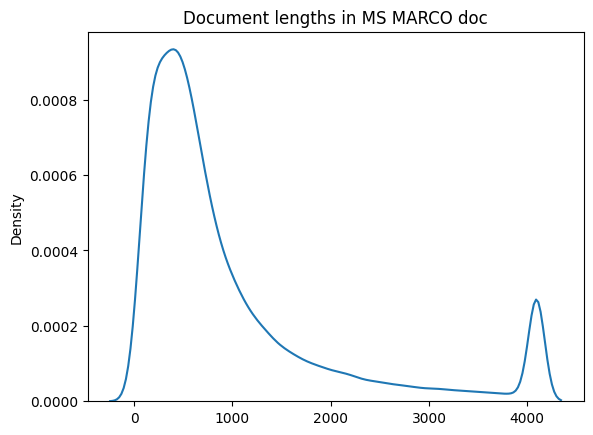

In [33]:
sns.kdeplot(capped_corpus_len)
plt.title("Document lengths in MS MARCO doc")
plt.show()

In [5]:
def plot_filtered_corpus_length(corpus_len_df, min_len=0, max_len=max(corpus_len_df["doc_len"])):
    filtered_corpus_len_df = corpus_len_df[(corpus_len_df["doc_len"] >= min_len) & (corpus_len_df["doc_len"] <= max_len)]
    print(f"Original corpus size: {len(corpus_len_df)}, Filtered corpus size: {len(filtered_corpus_len_df)}")
    plt.figure(figsize=(10, 6))
    sns.kdeplot(filtered_corpus_len_df)
    plt.title(f"Filtered Corpus Length Distribution ({min_len} - {max_len})")
    plt.xlabel("Document Length")
    plt.ylabel("Frequency")
    plt.show()

Original corpus size: 319190, Filtered corpus size: 186254


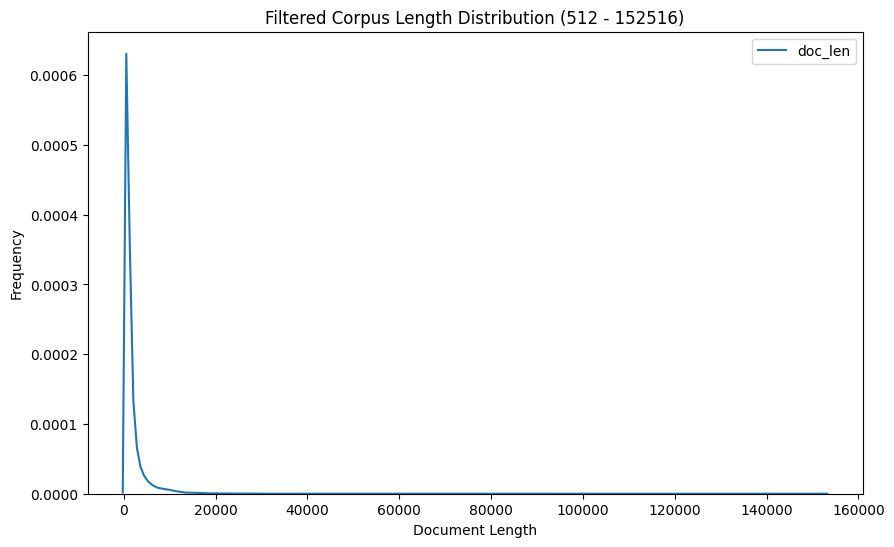

In [47]:
plot_filtered_corpus_length(corpus_len_df, 512)

In [2]:
corpus, queries, qrels = GenericDataLoader(data_folder="/Tmp/lvpoellhuber/datasets/msmarco-doc").load(split="test")

100%|██████████| 3201821/3201821 [01:27<00:00, 36469.31it/s]


In [3]:
corpus_len_df = {}
for qid, docrel in qrels.items():
    docid = list(docrel.keys())[0]
    doc = corpus[docid]
    doc_len = len(doc["text"].split(" ")) + len(doc["title"].split(" "))
    corpus_len_df[docid] = doc_len
corpus_len_df = pd.DataFrame.from_dict(corpus_len_df, orient="index", columns=["doc_len"])

Original corpus size: 5179, Filtered corpus size: 3020


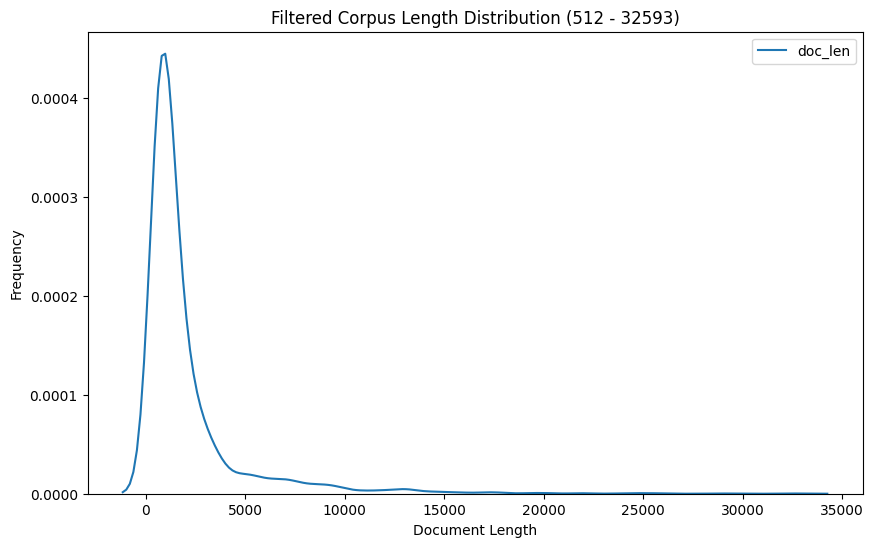

: 

In [ ]:
plot_filtered_corpus_length(corpus_len_df, 512)


In [3]:
corpus, queries, qrels = GenericDataLoader(data_folder="/Tmp/lvpoellhuber/datasets/msmarco-passage").load(split="train")

100%|██████████| 8841823/8841823 [00:20<00:00, 424605.74it/s]


In [5]:
len(qrels)

502939